In [1]:
import os
import time

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True



In [3]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.05
num_epochs = 15
batch_size = 1000

# Architecture
num_features = 784
#num_hidden_1 = 36
num_hidden_1 = 100

Device: cpu


In [6]:
# Load data
img = np.load(r"C:/Users/curti/Dropbox/Projects_all/479ML/Data/1000/sample_1000_image.npy")
lbl = np.load(r"C:/Users/curti/Dropbox/Projects_all/479ML/Data/1000/sample_1000_label.npy")

# Normalize image data.  0-255 to 0-1
img = img / 255
df = pd.DataFrame(np.concatenate((img, lbl), axis=1))

# Rename the last column as "label"
df.rename(columns={784:"label"}, inplace=True)

# Convert label column to float64 type
df['label'] = df['label'].astype('float64')

img = df.iloc[:, 0:-1].values
lbl = df['label'].values

#Split dataset
x_train1, x_test, y_train1, y_test = train_test_split(img, lbl, test_size = 0.20, random_state = 123, stratify = lbl)

#Convert dataframe to tensor
x_train1 = torch.tensor(x_train1).type('torch.FloatTensor')
y_train1 = torch.tensor(y_train1).type('torch.FloatTensor')

x_test = torch.tensor(x_test).type('torch.FloatTensor')
y_test = torch.tensor(y_test).type('torch.FloatTensor')

x_train1 = x_train1.reshape((-1,1,28,28))
x_test = x_test.reshape((-1,1,28,28))
print(x_train1.shape)
print(y_train1.shape)

torch.Size([276000, 1, 28, 28])
torch.Size([276000])


In [7]:
#Create dataloaders
train_dataset = TensorDataset(x_train1, y_train1)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

In [8]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([1000, 1, 28, 28])
Image label dimensions: torch.Size([1000])


In [9]:
##########################
### MODEL
##########################

class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        
        ### ENCODER
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        # The following to lones are not necessary, 
        # but used here to demonstrate how to access the weights
        # and use a different weight initialization.
        # By default, PyTorch uses Xavier/Glorot initialization, which
        # should usually be preferred.
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
    def encoder(self, x):
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)
        return encoded
    
    def decoder(self, encoded_x):
        logits = self.linear_2(encoded_x)
        decoded = torch.sigmoid(logits)
        return decoded
        

    def forward(self, x):
        ### ENCODER
        encoded = self.encoder(x)
        
        ### DECODER
        decoded = self.decoder(encoded)
        
        return decoded

    
torch.manual_seed(random_seed)
model = Autoencoder(num_features=num_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
## Training
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).float().to(device)
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.binary_cross_entropy(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/015 | Batch 000/276 | Cost: 0.7176
Epoch: 001/015 | Batch 050/276 | Cost: 0.2990
Epoch: 001/015 | Batch 100/276 | Cost: 0.2686
Epoch: 001/015 | Batch 150/276 | Cost: 0.2510
Epoch: 001/015 | Batch 200/276 | Cost: 0.2417
Epoch: 001/015 | Batch 250/276 | Cost: 0.2446
Time elapsed: 0.34 min
Epoch: 002/015 | Batch 000/276 | Cost: 0.2386
Epoch: 002/015 | Batch 050/276 | Cost: 0.2303
Epoch: 002/015 | Batch 100/276 | Cost: 0.2203
Epoch: 002/015 | Batch 150/276 | Cost: 0.2148
Epoch: 002/015 | Batch 200/276 | Cost: 0.2110
Epoch: 002/015 | Batch 250/276 | Cost: 0.2148
Time elapsed: 0.69 min
Epoch: 003/015 | Batch 000/276 | Cost: 0.2081
Epoch: 003/015 | Batch 050/276 | Cost: 0.1980
Epoch: 003/015 | Batch 100/276 | Cost: 0.1929
Epoch: 003/015 | Batch 150/276 | Cost: 0.1959
Epoch: 003/015 | Batch 200/276 | Cost: 0.1878
Epoch: 003/015 | Batch 250/276 | Cost: 0.1883
Time elapsed: 1.07 min
Epoch: 004/015 | Batch 000/276 | Cost: 0.1882
Epoch: 004/015 | Batch 050/276 | Cost: 0.1832
Epoch: 004/

Image batch dimensions: torch.Size([15, 1, 28, 28])
Image label dimensions: torch.Size([15])


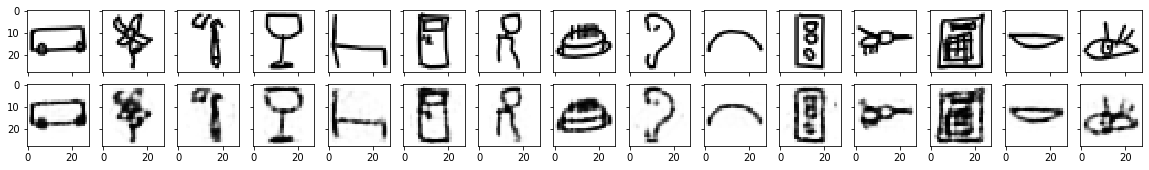

In [11]:
#Evaluation
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=15, 
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
# =============================================================

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')


In [15]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1000, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=1000, 
                          shuffle=False)

In [16]:
X_train_compr = np.ones((x_train1.shape[0], num_hidden_1))
y_train = np.ones(x_train1.shape[0])

start_idx = 0

for idx, (images, labels) in enumerate(train_loader): 
    features = images.view(-1, 28*28).to(device)
    decoded = model.encoder(features)
    X_train_compr[start_idx:start_idx+1000] = decoded.to(torch.device('cpu')).detach().numpy()
    y_train[start_idx:start_idx+1000] = labels
    start_idx += 1000

In [17]:
X_test_compr = np.ones((x_test.shape[0], num_hidden_1))
y_test = np.ones(x_test.shape[0])

start_idx = 0

for idx, (images, labels) in enumerate(test_loader): 
    features = images.view(-1, 28*28).to(device)
    decoded = model.encoder(features)
    X_test_compr[start_idx:start_idx+1000] = decoded.to(torch.device('cpu')).detach().numpy()
    y_test[start_idx:start_idx+1000] = labels
    start_idx += 1000